# Finding sparse solutions via Orthogonal Matching Pursuit (OMP)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba

## Problem description and performance metrics

Given measurement model
$$
\mathbf{y} \ = \ \mathbf{Ax} \ + \ \mathbf{n}
$$
where $ \mathbf{y} \in \mathbb{R}^{M}$ is the (compressed, M < N) measurement, $ \mathbf{A} \in \mathbb{R}^{M \text{x} N}$ is the measurement matrix, and $\mathbf{n} \in \mathbb{R}^{M}$ is the additive noise. Here, $\mathbf{x} \in \mathbb{R}^{N}$ is the unknown signal (to be estimated) with $s ≪ N$ non-zero elements. The indices of the non-zero entries of $\mathbf{x}$ (also known as the support of $\mathbf{x}$) is denoted by $S = \{ i |x_{i} \neq 0\}$, with $|S| = s$.

Let $\mathbf{\hat{x}}$ is the estimate of $\mathbf{x}$ obtained from the OMP. To measure the performance of the OMP, we use the normalized error defined as
$$
\frac{||\mathbf{x} - \mathbf{\hat{x}}||_{2}}{||\mathbf{x}||_2}
$$
where $||\mathbf{x}||_2$ is the $L_2$ norm of $\mathbf{x}$. The average Normalized Error is obtained by averaging the Normalized Error over 2000 Monte Carlo runs.

## Experimental Setup

- Generate **A** as a random matrix with independent and identically distributed entries drawn from the standard normal distribution. Normalize the columns of **A**.
- Generate the sparse vector **x** with random support of cardinality $s$ (i.e. $s$ indices are generated randomly from integers $1 \text{to} N$), and the non-zero entries are drawn as uniform random variables in the range $[-10, -1] \bigcup [1, 10]$.
- The entries of noise **n** are drawn independently from the normal distribution with standard deviation $\sigma$ and zero mean.
- For each cardinality $s \in [1, s_{max}]$, the average Normalized Error should be computed by repeating steps 2000 times and averaging the results over these 2000 Monte Carlo runs.

## Implementation of OMP

The algorithm for OMP is as follows:
* Initialize a residual vector $\mathbf{r} = \mathbf{y}$ and an empty support set $\hat{\mathbf{S}} = \emptyset$.
* Calculate the maximum correlated vector $\mathbf{c} = \max{\mathbf{A}^T \mathbf{r}}$. This vector corresponds to the column of $\mathbf{A}$ that is most correlated with the residual vector $\mathbf{r}$. So, we can say that all correlated vectors obtained at the end of the algorithm should span ${\mathbf{y}}$.
* Add the index of the correlated vector (column of **A**) to the supported set to be estimated.
* Now we would solve the optimizing criteria mentioned below:
$$
\hat{\mathbf{v}}_{k} = \underset{\mathbf{v}}{\text{argmin}} ||\mathbf{y} - \mathbf{x'}||_2^2 
$$
where, $\mathbf{x'} \in span \{a_{i}| i \in \hat{\mathbf{S}}\}$, and $\hat{\mathbf{v}}_{k}$ will be the orthogonal projection of $\mathbf{y}$ onto the subspace spanned by the columns of $\mathbf{A}$ corresponding to the indices in $\hat{\mathbf{S}}$.
* Update the residual vector $\mathbf{r} = \mathbf{y} - \hat{\mathbf{v}}_{k}$.
* When the algorithm converges (we will terminate the loop using the condition mentioned below), the support set $\hat{\mathbf{S}}$ will contain the indices of the non-zero entries of $\mathbf{x}$. And the estimate of $\mathbf{x}$ will be $\hat{\mathbf{x}}$, which is defined as $\hat{\mathbf{x}}_k = \hat{\mathbf{\alpha}}_{i}$ (where $k =\hat{\mathbf{S}}_{i}$).
* From previously mentioned point we can say that $\mathbf{y}$ is spanned by columns of $\mathbf{A}$ with coefficients (solution of normal equation, $\hat{\mathbf{\alpha}}$) obtained in the $\hat{\mathbf{x}}$.

### Solving the optimizing criteria

The optimizing criteria can be solved using the following steps:
* As we know, $\mathbf{x'} \in span \{a_{i}| i \in \hat{\mathbf{S}}\}$, so we write $\mathbf{x'} = \Sigma^{k}_i \alpha_i a_i$; where $a_i$ are the columns of $\mathbf{A}$ which has maximum correlation with residual vector as mentioned above. Hence, our goal is to find the values of $\alpha_i$ to satisfy given optimality condition.
* We would differentiate the above equation with respect to $\alpha_i$ and equate it to zero to find the optimal values of $\alpha_i$.
* We would get the following equation:
$$
y^{T}a_i = (\Sigma^{k}_{j}\alpha_j a_j)^{T}a_i \\
y^{T}a_i = (\Sigma^{k}_{j}\alpha_j a_j^{T}a_i)
$$
We got the below equation by transposing terms on both sides of equation. Since $a_j^{T}a_i$ is a scalar, we can write it as $a_i^{T}a_j$ and then we can write the above equation as:
$$
a_i^{T}y = (\Sigma^{k}_{j}\alpha_j a_i^{T}a_j)
$$
* To solve the above equation we will write the equation in matrix form:
$$
\begin{bmatrix}
y^{T}a_1 & y^{T}a_2 & \cdots & y^{T}a_k
\end{bmatrix}^{T}
=\begin{bmatrix}
a_1^{T}a_1 & a_1^{T}a_2 & \cdots & a_1^{T}a_k \\
a_2^{T}a_1 & a_2^{T}a_2 & \cdots & a_2^{T}a_k \\
\vdots & \vdots & \ddots & \vdots \\
a_k^{T}a_1 & a_k^{T}a_2 & \cdots & a_k^{T}a_k
\end{bmatrix} 
\begin{bmatrix}
\alpha_1 \\
\alpha_2 \\
\vdots \\
\alpha_k
\end{bmatrix} \\
\begin{bmatrix}
y^{T}a_1 & y^{T}a_2 & \cdots & y^{T}a_k
\end{bmatrix}^{T}
=\begin{bmatrix}
a_1^{T} \\
a_2^{T} \\
\vdots \\
a_k^{T}
\end{bmatrix}
\begin{bmatrix}
a_1 & a_2 & \cdots & a_k
\end{bmatrix}
\begin{bmatrix}
\alpha_1 \\
\alpha_2 \\
\vdots \\
\alpha_k
\end{bmatrix} \\
$$
Now let $\hat{\mathbf{A}} = \begin{bmatrix}a_1 & a_2 & \cdots & a_k\end{bmatrix}$ and $\hat{\mathbf{\alpha}} = \begin{bmatrix}\alpha_1 & \alpha_2 & \cdots & \alpha_k\end{bmatrix}^{T}$.
* Above equation can be written as:
$$
\hat{\mathbf{A}}^{T}y = \hat{\mathbf{A}}^{T}\hat{\mathbf{A}}\hat{\mathbf{\alpha}}
$$
* Solution to optimality condition is given by:
$$
\hat{\mathbf{\alpha}} = (\hat{\mathbf{A}}^{T}\hat{\mathbf{A}})^{-1}\hat{\mathbf{A}}^{T}y
$$
* The matrix $(\hat{\mathbf{A}}^{T}\hat{\mathbf{A}})^{-1}\hat{\mathbf{A}}^{T}$ is called pseudoinverse $({\mathbf{A}^{\dagger}})$ of $\hat{\mathbf{A}}$.
* We now have $\mathbf{x'} = \hat{\mathbf{A}}\hat{\mathbf{\alpha}}$ to satisfy the optimality condition. Hence, solution to the optimality condition is given by $\hat{\mathbf{v}}_{k} = \hat{\mathbf{A}}\hat{\mathbf{\alpha}}$.

### Termination criteria of OMP

The mentioned OMP algorithm can be terminated using one of the conditions mentioned below:
- When the product $\mathbf{A}^{T}\mathbf{r}$ which is correlation measure is less than a threshold value (here used as 0.1).
- When the error $||y-\mathbf{A}\hat{\mathbf{x}}||_2$ is less than a threshold value (here used as $10^{-3}$).
- When the error $||y-\mathbf{A}\hat{\mathbf{x}}||_2$ is less than a set noise threshold value (denoted as $||\mathbf{n}||_{2}$).

## Function OMP

In [2]:
def OMP(A, y, s, noise, n_norm):

    N = A.shape[1]
    M = A.shape[0]
    k = []                           #Estimate of support
    a = []                           #A_cap
    r = y                            #Residual

    while (max(np.abs(A.T @ r)) > 0.1):
        
        x_omp = np.zeros((N, 1))
        #Find the index of the maximum value in the vector A.T @ b
        j = np.argmax(np.abs(A.T @ r))
        #Add the index to the list of estimate of support
        k.append(j)
        if type(a) == list:
            a.append(A[:, j].reshape(M, 1))
            a = np.array(a)
            a = a.reshape(M, 1)
        else:
            a = np.concatenate((a, A[:, j].reshape(M, 1)), axis=1)
        # Calculation of the above mentioned pseudoinverse; Solution of the normal equation
        a_temp = (a.T) @ a
        a_temp = np.linalg.inv(a_temp)
        # alpha is the solution of the normal equation; Mentioned in the explanention above
        alpha = (a_temp @ a.T) @ y
        b = a @ alpha
        #Update Residual
        r = y - b
        # Current estimate of the sparse vector
        for i in range(len(k)):
            x_omp[k[i]] = alpha[i]
        error = np.linalg.norm(y - (A @ x_omp))
        # Termination conditions
        if noise == True:
            # Noisy case and error is less than the noise norm
            if error < n_norm:
                break
            # When the sparsity os the signal is known
            if s == k:
                break
        # Error is less than the threshold
        if error < 1e-3:
            break

    # Final estimate of the sparse vector
    x_omp = np.zeros((N, 1))
    for i in range(len(k)):
        x_omp[k[i]] = alpha[i]
    # len(k) is estimate of the sparsity of the signal
    return x_omp, len(k)

## Noiseless case: (n = 0)

Here $ \mathbf{n} = 0$, so $ \mathbf{y} = \mathbf{Ax}$. We will stop OMP iterations when $ ||\mathbf{y} - \mathbf{A}\mathbf{\hat{x}}||_2 < 10^{-3}$. The probability of Exact Support Recovery (ESR) is defined as the probability that the support of $\mathbf{\hat{x}}$ is exactly the same as the support of $\mathbf{x}$ i.e. $S = \hat{S}$ by averaging over 2000 Monte Carlo runs (2000 random realizations of $\mathbf{A}$).

### N = 20

In [16]:
N = 20
s_max = 19
A_normal_upper = 1


esr_plot = []
avg_error_plot = []

A = []

for M in range(N):
    if M == 0:
        continue
    
    avg_error_temp = []
    esr_temp = []

    for s in range(s_max):
        if s == 0:
            continue
        
        avg_error = 0
        esr = 0
        for iter in range(2000):

            A = np.random.normal(0, A_normal_upper, (M, N))
            A = A / np.linalg.norm(A, axis=0)
            x = np.zeros((N, 1))
            
            j = random.sample(range(N), s)                
            x[j] = random.randint(-10, 10)
            while sum(x[j] == 0):
                x[j] = random.randint(-10, 10)
            
            y = A @ x
            x_omp, s_cap = OMP(A, y, 0, False, -1)             #s passed as zero;
            x_diff = x - x_omp                                 #As s is not known in noiseless case
            error = np.linalg.norm(x_diff)
            error = error / np.linalg.norm(x)
            avg_error += error
            if s_cap == s:
                esr += 1
        
        avg_error = avg_error / 2000
        esr = esr / 2000
        
        avg_error_temp.append(avg_error)
        esr_temp.append(esr)
    
    avg_error_plot.append(avg_error_temp)
    esr_plot.append(esr_temp)

avg_error_plot = np.array(avg_error_plot)
esr_plot = np.array(esr_plot)



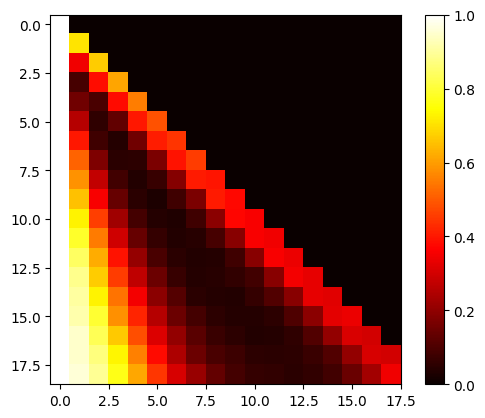

In [17]:
img1 = plt.imshow(esr_plot, cmap='hot', interpolation='nearest')
plt.colorbar(img1)
plt.show()

#### Exact Support Recover Probability plot for different values of M (on y) and S (on x) (N = 20)

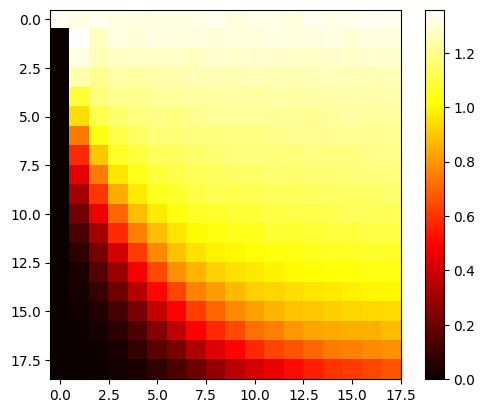

In [18]:
img = plt.imshow(avg_error_plot, cmap='hot', interpolation='nearest')
plt.colorbar(img)
plt.show()

#### Normalized Error plot on different values of M and S (N = 20)

### For N = 50

In [27]:
N = 50
s_max = 49
A_normal_upper = 1

esr_plot_2 = []
avg_error_plot_2 = []

for M in range(N):
    if M % 2 == 0:
        continue
    
    avg_error_temp_2 = []
    esr_temp_2 = []

    for s in range(s_max):
        if s % 2 == 0:
            continue
        
        avg_error_2 = 0
        esr_2 = 0
        for iter in range(2000):

            A = np.random.normal(0, A_normal_upper, (M, N))
            A = A / np.linalg.norm(A, axis=0)
            
            x = np.zeros((N, 1))
            
            j = random.sample(range(N), s)                
            x[j] = random.randint(-10, 10)
            while sum(x[j] == 0):
                x[j] = random.randint(-10, 10)
            
            y = A @ x
            x_omp, s_cap = OMP(A, y, 0, False, -1)
            x_diff = x - x_omp
            error = np.linalg.norm(x_diff)
            error = error / np.linalg.norm(x)
            avg_error_2 += error
            if s_cap == s:
                esr_2 += 1
        
        avg_error_2 = avg_error_2 / 2000
        esr_2 = esr_2 / 2000
        
        avg_error_temp_2.append(avg_error_2)
        esr_temp_2.append(esr_2)
    
    avg_error_plot_2.append(avg_error_temp_2)
    esr_plot_2.append(esr_temp_2)

avg_error_plot_2 = np.array(avg_error_plot_2)
esr_plot_2 = np.array(esr_plot_2)

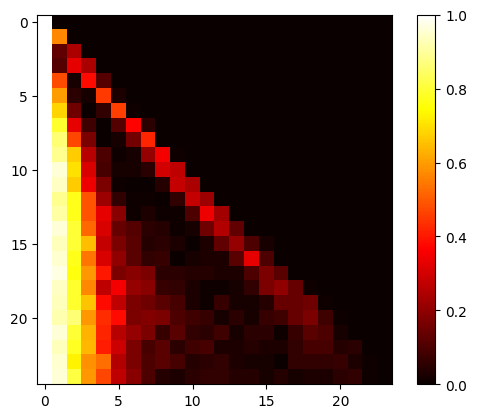

In [28]:
img1_2 = plt.imshow(esr_plot_2, cmap='hot', interpolation='nearest')
plt.colorbar(img1_2)
plt.show()

### ESR Plot for different values of M and S (N = 50)

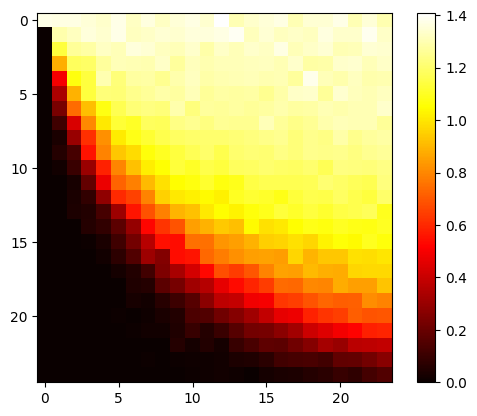

In [29]:
img_2 = plt.imshow(avg_error_plot_2, cmap='hot', interpolation='nearest')
plt.colorbar(img_2)
plt.show()

### Normalized Error plot on different values of M and S (N = 50)

### For N = 100

In [78]:
N = 100
s_max = 99
A_normal_upper = 1

esr_plot_3 = []
avg_error_plot_3 = []

for M in range(N):
    if M % 4 == 0:
        continue
    
    avg_error_temp_3 = []
    esr_temp_3 = []

    for s in range(s_max):
        if s % 4 == 0:
            continue
        
        avg_error_3 = 0
        esr_3 = 0
        for iter in range(2000):

            A = np.random.normal(0, A_normal_upper, (M, N))
            A = A / np.linalg.norm(A, axis=0)
            x = np.zeros((N, 1))
            x = np.zeros((N, 1))
            
            j = random.sample(range(N), s)                
            x[j] = random.randint(-10, 10)
            while sum(x[j] == 0):
                x[j] = random.randint(-10, 10)
            
            y = A @ x
            x_omp, s_cap = OMP(A, y, 0, False, -1)
            x_diff = x - x_omp
            error = np.linalg.norm(x_diff)
            error = error / np.linalg.norm(x)
            avg_error_3 += error
            if s_cap == s:
                esr_3 += 1
        
        avg_error_3 = avg_error_3 / 2000
        esr_3 = esr_3 / 2000
        
        avg_error_temp_3.append(avg_error_3)
        esr_temp_3.append(esr_3)
    
    avg_error_plot_3.append(avg_error_temp_3)
    esr_plot_3.append(esr_temp_3)

avg_error_plot_3 = np.array(avg_error_plot_3)
esr_plot_3 = np.array(esr_plot_3)

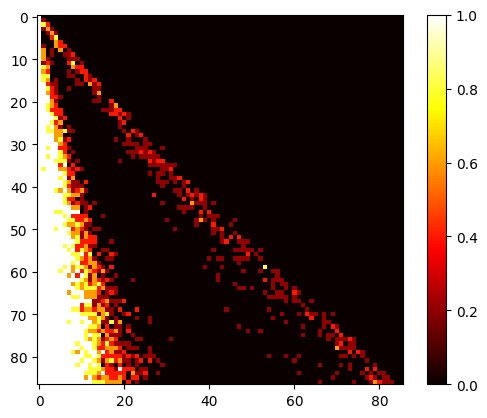

In [79]:
img1_3 = plt.imshow(esr_plot_3, cmap='hot', interpolation='nearest')
plt.colorbar(img1_3)
plt.show()

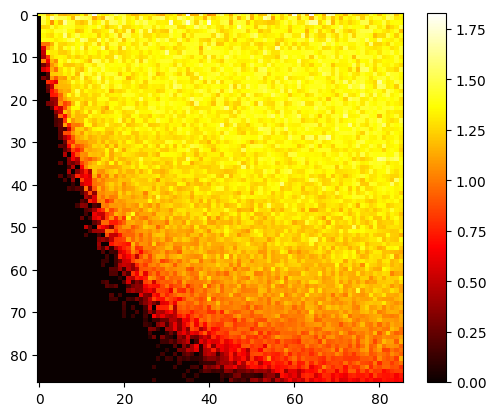

In [80]:
img_3 = plt.imshow(avg_error_plot_3, cmap='hot', interpolation='nearest')
plt.colorbar(img_3)
plt.show()

## Noisy case: (n $\neq$ 0)

### (a) Assume that sparsity $s$ is known

Here we will implement OMP which will be terminated when the algorithm selects first $s$ columns of $\mathbf{A}$.
Here $ \mathbf{n} \neq 0$, so $ \mathbf{y} = \mathbf{Ax} + \mathbf{n}$. We will stop OMP iterations when $ ||\mathbf{y} - \mathbf{A}\mathbf{\hat{x}}||_2 < 10^{-6}$. The probability of Exact Support Recovery (ESR) is defined as the probability that the support of $\mathbf{\hat{x}}$ is exactly the same as the support of $\mathbf{x}$ i.e. $S = \hat{S}$ by averaging over 2000 Monte Carlo runs (2000 random realizations of $\mathbf{A}$).

### For N = 20, $\sigma = 0.1, 10$

In [57]:
N = 20
s_max = 19
A_normal_upper = 1
sigma = [0.1, 10]

success_plot = []
success_plot_large = []

for M in range(N):
    if M == 0:
        continue

    success_temp = []
    success_temp_large = []

    for s in range(s_max):
        if s == 0:
            continue
        
        success = 0
        success_large = 0
        for iter in range(2000):

            A = np.random.normal(0, A_normal_upper, (M, N))
            A = A / np.linalg.norm(A, axis=0)

            x = np.zeros((N, 1))
            
            j = random.sample(range(N), s)                
            x[j] = random.randint(-10, 10)
            while sum(x[j] == 0):
                x[j] = random.randint(-10, 10)
            
            n = np.random.normal(0, sigma[0], (M, 1))
            n_large = np.random.normal(0, sigma[1], (M, 1))

            y = ((A @ x) + n)
            y_large = ((A @ x) + n_large)
            x_omp, s_cap = OMP(A, y, s, True, 0)
            x_omp_large, s_cap_large = OMP(A, y_large, s, True, 0)  
            x_diff = x - x_omp
            x_diff_large = x - x_omp_large
            error = np.linalg.norm(x_diff)
            error = error / np.linalg.norm(x)
            error_large = np.linalg.norm(x_diff_large)
            error_large = error_large / np.linalg.norm(x)
            if error < 1e-3:
                success += 1
            if error_large < 1e-3:
                success_large += 1
        
        success = success / 2000
        success_large = success_large / 2000
        
        success_temp.append(success)
        success_temp_large.append(success_large)
    
    success_plot.append(success_temp)
    success_plot_large.append(success_temp_large)

success_plot = np.array(success_plot)
success_plot_large = np.array(success_plot_large)

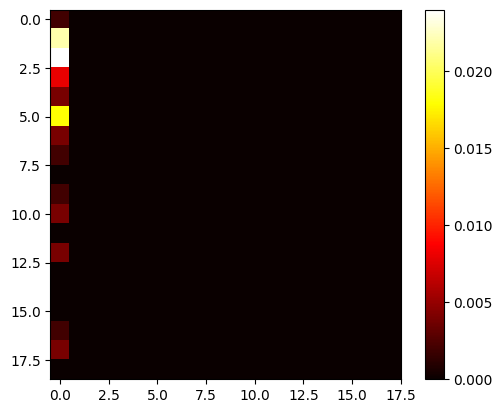

In [58]:
imgn = plt.imshow(success_plot, cmap='hot')
plt.colorbar(imgn)
plt.show()

### Sigma is small in the above plot

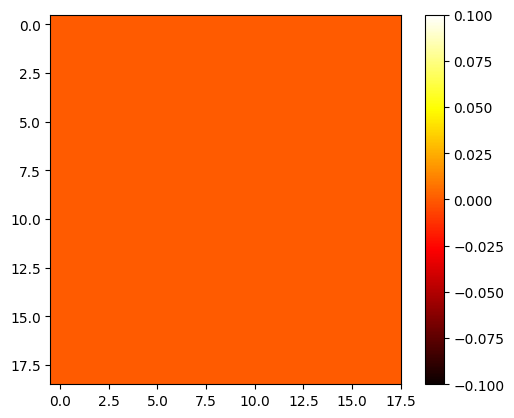

In [59]:
imgn_large = plt.imshow(success_plot_large, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_large)
plt.show()

### Sigma is large in the above plot

### N = 50, $\sigma = 0.1, 10$

In [60]:
N = 50
s_max = 49
A_normal_upper = 1
sigma = [0.1, 10]

success_plot_1 = []
success_plot_large_1 = []

for M in range(N):
    if M % 2 == 0:
        continue

    success_temp = []
    success_temp_large = []

    for s in range(s_max):
        if s % 2 == 0:
            continue
        
        success = 0
        success_large = 0
        for iter in range(2000):

            A = np.random.normal(0, A_normal_upper, (M, N))
            A = A / np.linalg.norm(A, axis=0)

            x = np.zeros((N, 1))
            
            j = random.sample(range(N), s)                
            x[j] = random.randint(-10, 10)
            while sum(x[j] == 0):
                x[j] = random.randint(-10, 10)
            
            n = np.random.normal(0, sigma[0], (M, 1))
            n_large = np.random.normal(0, sigma[1], (M, 1))

            y = ((A @ x) + n)
            y_large = ((A @ x) + n_large)
            x_omp, s_cap = OMP(A, y, s, True, 0)
            x_omp_large, s_cap_large = OMP(A, y_large, s, True, 0)  
            x_diff = x - x_omp
            x_diff_large = x - x_omp_large
            error = np.linalg.norm(x_diff)
            error = error / np.linalg.norm(x)
            error_large = np.linalg.norm(x_diff_large)
            error_large = error_large / np.linalg.norm(x)
            if error < 1e-3:
                success += 1
            if error_large < 1e-3:
                success_large += 1
        
        success = success / 2000
        success_large = success_large / 2000
        
        success_temp.append(success)
        success_temp_large.append(success_large)
    
    success_plot_1.append(success_temp)
    success_plot_large_1.append(success_temp_large)

success_plot_1 = np.array(success_plot_1)
success_plot_large_1 = np.array(success_plot_large_1)

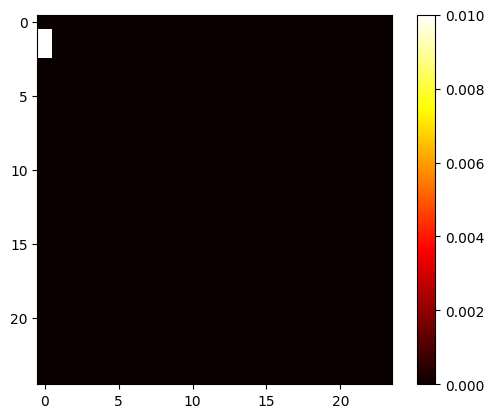

In [61]:
imgn_1 = plt.imshow(success_plot_1, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_1)
plt.show()

### Sigma is small in the above plot

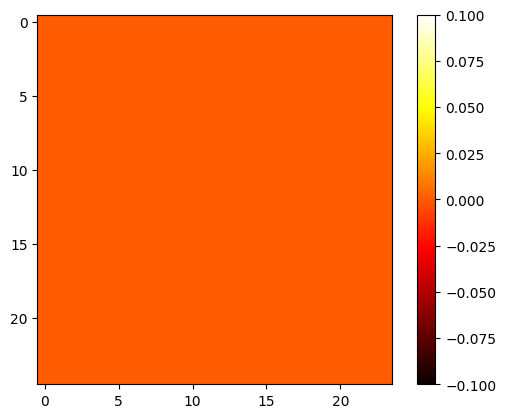

In [62]:
imgn_large_1 = plt.imshow(success_plot_large_1, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_large_1)
plt.show()

### Sigma is large in the above plot

### N = 100, $\sigma = 0.1, 10$

In [81]:
N = 100
s_max = 99
A_normal_upper = 1
sigma = [0.1, 10]

success_plot_2 = []
success_plot_large_2 = []

for M in range(N):
    if M % 4 == 0:
        continue

    success_temp = []
    success_temp_large = []

    for s in range(s_max):
        if s % 4 == 0:
            continue
        
        success = 0
        success_large = 0
        for iter in range(1000):

            A = np.random.normal(0, A_normal_upper, (M, N))
            A = A / np.linalg.norm(A, axis=0)

            x = np.zeros((N, 1))
            
            j = random.sample(range(N), s)                
            x[j] = random.randint(-10, 10)
            while sum(x[j] == 0):
                x[j] = random.randint(-10, 10)
            
            n = np.random.normal(0, sigma[0], (M, 1))
            n_large = np.random.normal(0, sigma[1], (M, 1))

            y = ((A @ x) + n)
            y_large = ((A @ x) + n_large)
            x_omp, s_cap = OMP(A, y, s, True, 0)
            x_omp_large, s_cap_large = OMP(A, y_large, s, True, 0)  
            x_diff = x - x_omp
            x_diff_large = x - x_omp_large
            error = np.linalg.norm(x_diff)
            error = error / np.linalg.norm(x)
            error_large = np.linalg.norm(x_diff_large)
            error_large = error_large / np.linalg.norm(x)
            if error < 1e-3:
                success += 1
            if error_large < 1e-3:
                success_large += 1
        
        success = success / 1000
        success_large = success_large / 1000
        
        success_temp.append(success)
        success_temp_large.append(success_large)
    
    success_plot_2.append(success_temp)
    success_plot_large_2.append(success_temp_large)

success_plot_2 = np.array(success_plot_2)
success_plot_large_2 = np.array(success_plot_large_2)

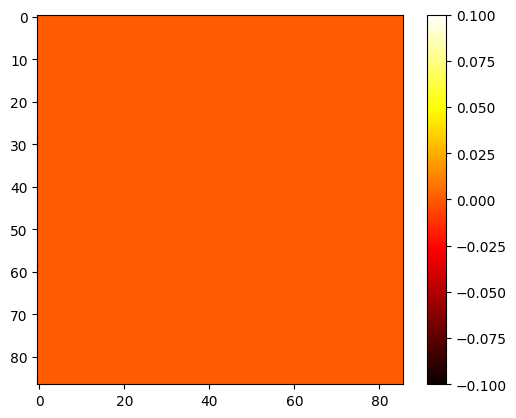

In [82]:
imgn_2 = plt.imshow(success_plot_2, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_2)
plt.show()

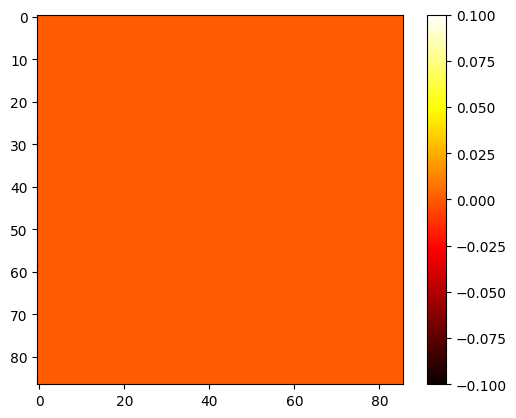

In [83]:
imgn_large_2 = plt.imshow(success_plot_large_2, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_large_2)
plt.show()

### (b) Assume that sparsity $s$ is unknown

### N = 20, $\sigma = 0.1, 10$

In [72]:
N = 20
s_max = 19
A_normal_upper = 1
sigma = [0.1, 10]

success_plot = []
success_plot_large = []

for M in range(N):
    if M == 0:
        continue

    success_temp = []
    success_temp_large = []

    for s in range(s_max):
        if s == 0:
            continue
        
        success = 0
        success_large = 0
        for iter in range(1000):

            A = np.random.normal(0, A_normal_upper, (M, N))
            A = A / np.linalg.norm(A, axis=0)

            x = np.zeros((N, 1))
            
            j = random.sample(range(N), s)                
            x[j] = random.randint(-10, 10)
            while sum(x[j] == 0):
                x[j] = random.randint(-10, 10)
            
            n = np.random.normal(0, sigma[0], (M, 1))
            n_large = np.random.normal(0, sigma[1], (M, 1))

            y = ((A @ x) + n)
            y_large = ((A @ x) + n_large)
            x_omp, s_cap = OMP(A, y, 0, True, np.linalg.norm(n))
            x_omp_large, s_cap_large = OMP(A, y_large, 0, True, np.linalg.norm(n_large))  
            x_diff = x - x_omp
            x_diff_large = x - x_omp_large
            error = np.linalg.norm(x_diff)
            error = error / np.linalg.norm(x)
            error_large = np.linalg.norm(x_diff_large)
            error_large = error_large / np.linalg.norm(x)
            if error < 1e-3:
                success += 1
            if error_large < 1e-3:
                success_large += 1
        
        success = success / 1000
        success_large = success_large / 1000
        
        success_temp.append(success)
        success_temp_large.append(success_large)
    
    success_plot.append(success_temp)
    success_plot_large.append(success_temp_large)

success_plot = np.array(success_plot)
success_plot_large = np.array(success_plot_large)

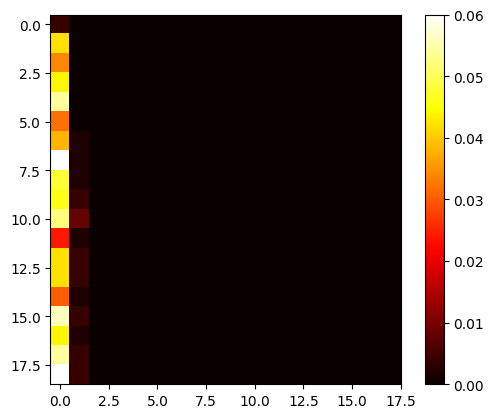

In [65]:
imgn_3 = plt.imshow(success_plot, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_3)
plt.show()

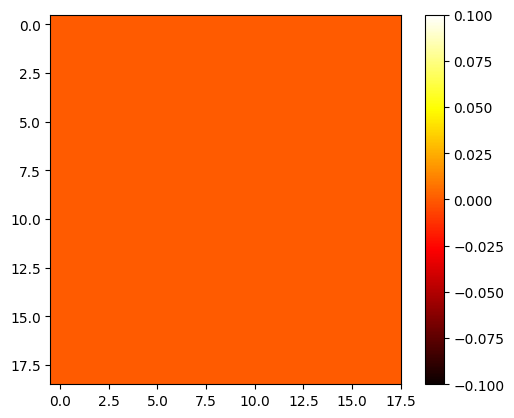

In [66]:
imgn_large_3 = plt.imshow(success_plot_large, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_large_3)
plt.show()

### N = 50, $\sigma = 0.1, 10$

In [67]:
N = 50
s_max = 49
A_normal_upper = 1
sigma = [0.1, 10]

success_plot = []
success_plot_large = []

for M in range(N):
    if M % 2 == 0:
        continue

    success_temp = []
    success_temp_large = []

    for s in range(s_max):
        if s % 2 == 0:
            continue
        
        success = 0
        success_large = 0
        for iter in range(1000):

            A = np.random.normal(0, A_normal_upper, (M, N))
            A = A / np.linalg.norm(A, axis=0)

            x = np.zeros((N, 1))
            
            j = random.sample(range(N), s)                
            x[j] = random.randint(-10, 10)
            while sum(x[j] == 0):
                x[j] = random.randint(-10, 10)
            
            n = np.random.normal(0, sigma[0], (M, 1))
            n_large = np.random.normal(0, sigma[1], (M, 1))

            y = ((A @ x) + n)
            y_large = ((A @ x) + n_large)
            x_omp, s_cap = OMP(A, y, 0, True, np.linalg.norm(n))
            x_omp_large, s_cap_large = OMP(A, y_large, 0, True, np.linalg.norm(n_large))  
            x_diff = x - x_omp
            x_diff_large = x - x_omp_large
            error = np.linalg.norm(x_diff)
            error = error / np.linalg.norm(x)
            error_large = np.linalg.norm(x_diff_large)
            error_large = error_large / np.linalg.norm(x)
            if error < 1e-3:
                success += 1
            if error_large < 1e-3:
                success_large += 1
        
        success = success / 1000
        success_large = success_large / 1000
        
        success_temp.append(success)
        success_temp_large.append(success_large)
    
    success_plot.append(success_temp)
    success_plot_large.append(success_temp_large)

success_plot = np.array(success_plot)
success_plot_large = np.array(success_plot_large)

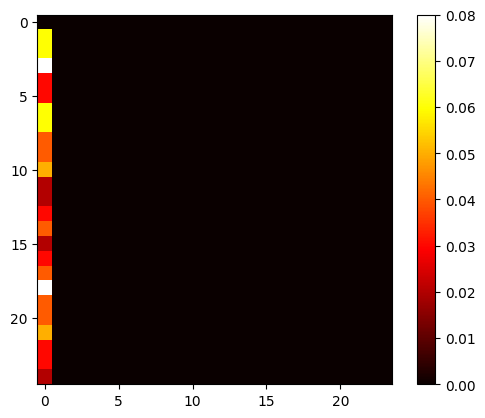

In [71]:
imgn_4 = plt.imshow(success_plot, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_4)
plt.show()

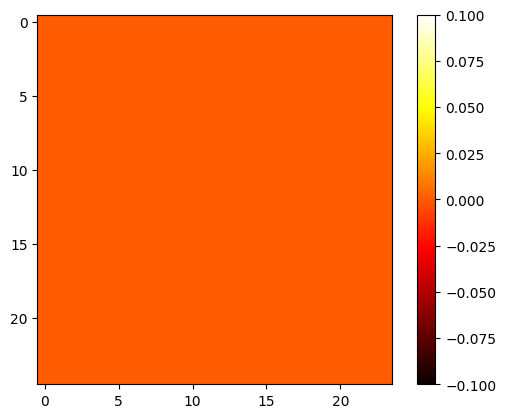

In [69]:
imgn_large_4 = plt.imshow(success_plot_large, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_large_4)
plt.show()

### N = 100, $\sigma = 0.1, 10$

In [84]:
N = 100
s_max = 99
A_normal_upper = 1
sigma = [0.1, 10]

success_plot = []
success_plot_large = []

for M in range(N):
    if M % 8 == 0:
        continue

    success_temp = []
    success_temp_large = []

    for s in range(s_max):
        if s % 8 == 0:
            continue
        
        success = 0
        success_large = 0
        for iter in range(5):

            A = np.random.normal(0, A_normal_upper, (M, N))
            A = A / np.linalg.norm(A, axis=0)

            x = np.zeros((N, 1))
            
            j = random.sample(range(N), s)                
            x[j] = random.randint(-10, 10)
            while sum(x[j] == 0):
                x[j] = random.randint(-10, 10)
            
            n = np.random.normal(0, sigma[0], (M, 1))
            n_large = np.random.normal(0, sigma[1], (M, 1))

            y = ((A @ x) + n)
            y_large = ((A @ x) + n_large)
            x_omp, s_cap = OMP(A, y, 0, True, np.linalg.norm(n))
            x_omp_large, s_cap_large = OMP(A, y_large, 0, True, np.linalg.norm(n_large))  
            x_diff = x - x_omp
            x_diff_large = x - x_omp_large
            error = np.linalg.norm(x_diff)
            error = error / np.linalg.norm(x)
            error_large = np.linalg.norm(x_diff_large)
            error_large = error_large / np.linalg.norm(x)
            if error < 1e-3:
                success += 1
            if error_large < 1e-3:
                success_large += 1
        
        success = success / 5
        success_large = success_large / 5
        
        success_temp.append(success)
        success_temp_large.append(success_large)
    
    success_plot.append(success_temp)
    success_plot_large.append(success_temp_large)

success_plot = np.array(success_plot)
success_plot_large = np.array(success_plot_large)

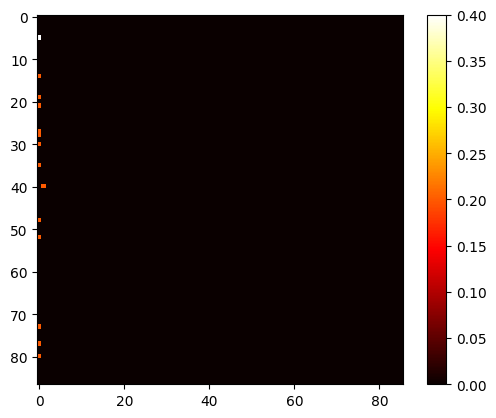

In [85]:
imgn_5 = plt.imshow(success_plot, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_5)
plt.show()

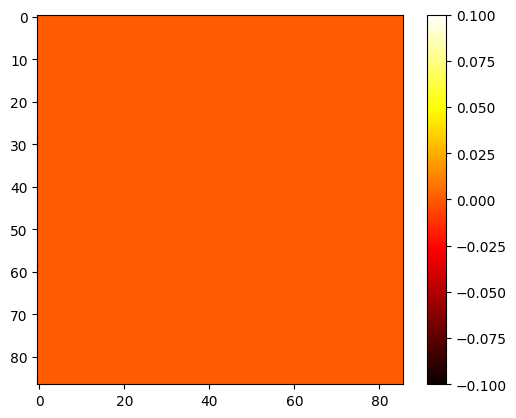

In [86]:
imgn_large_5 = plt.imshow(success_plot_large, cmap='hot', interpolation='nearest')
plt.colorbar(imgn_large_5)
plt.show()

In [2]:
import scipy.io

In [3]:
mat = scipy.io.loadmat('./../data_2/Y1 Y2 Y3 and A1 A2 A3.mat')

In [4]:
A1 = mat['A1']
A2 = mat['A2']
A3 = mat['A3']
Y1 = mat['y1']
Y2 = mat['y2']
Y3 = mat['y3']
A1 = np.array(A1)
A2 = np.array(A2)
A3 = np.array(A3)
Y1 = np.array(Y1)
Y2 = np.array(Y2)
Y3 = np.array(Y3)

In [90]:
y_temp = Y1.reshape((24,40))

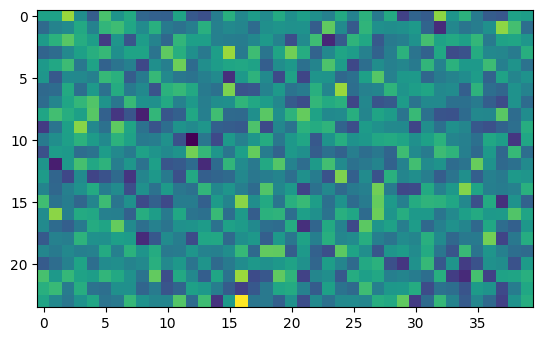

In [91]:
plt.imshow(y_temp)

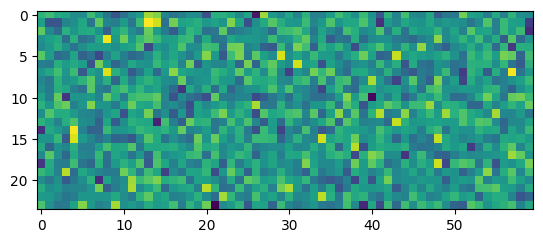

In [93]:
y_temp2 = Y2.reshape((24,60))
plt.imshow(y_temp2)

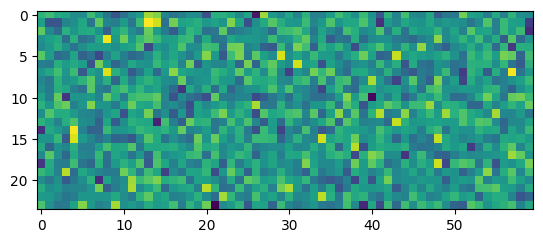

In [94]:
y_temp2 = Y2.reshape((24,60))
plt.imshow(y_temp2)

In [95]:
X1_OMP, S1_OMP = OMP(A1, Y1, 0, True, 0)

840
(960, 14400)


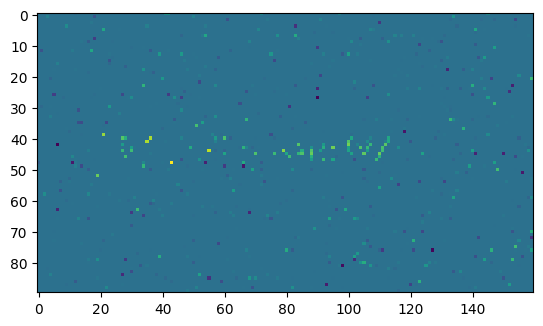

In [108]:
X1_temp = X1_OMP.reshape((160,90))
plt.imshow(X1_temp.T)
print(S1_OMP)
print(A1.shape)

In [98]:
X2_OMP, S2_OMP = OMP(A2, Y2, 0, True, 0)

374
(1440, 14400)


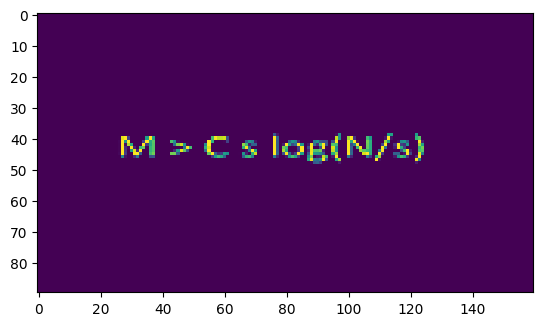

In [110]:
X2_temp = X2_OMP.reshape((160,90))
plt.imshow(X2_temp.T)
print(S2_OMP)
print(A2.shape)

In [100]:
X3_OMP, S3_OMP = OMP(A3, Y3, 0, True, 0)

357
(2880, 14400)


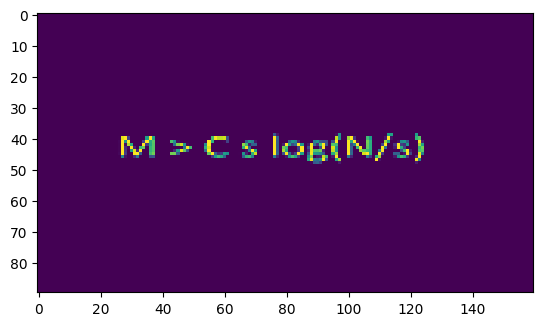

In [109]:
X3_temp = X3_OMP.reshape((160,90))
plt.imshow(X3_temp.T)
print(S3_OMP)
print(A3.shape)

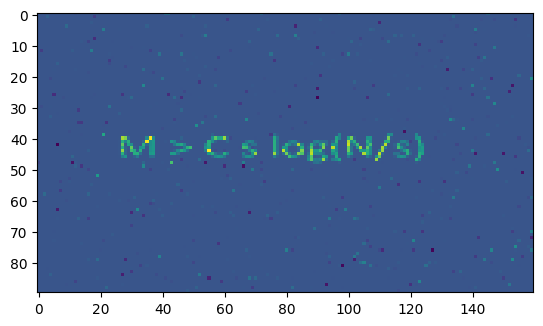

In [103]:
plt.imshow((X1_temp  + X2_temp + X3_temp).T)

### Least Squares solution

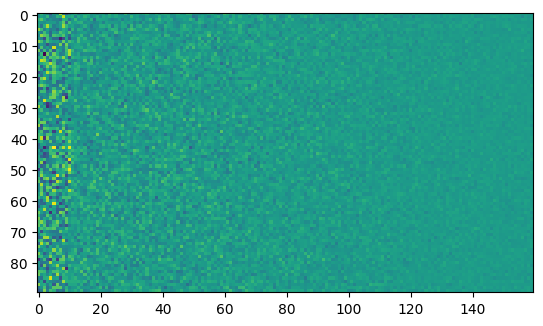

In [5]:
X1_Ls = np.linalg.inv(A1.T @ A1) @ A1.T @ Y1
plt.imshow(X1_Ls.reshape(160, 90).T)

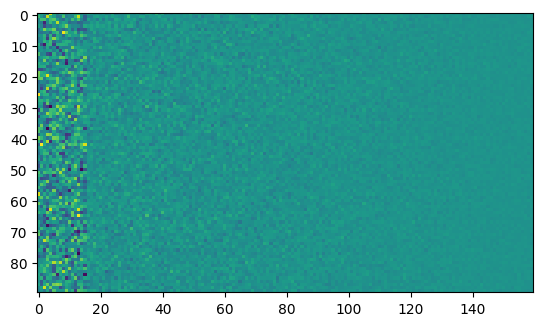

In [6]:
X2_Ls = np.linalg.inv(A2.T @ A2) @ A2.T @ Y2
plt.imshow(X2_Ls.reshape(160, 90).T)

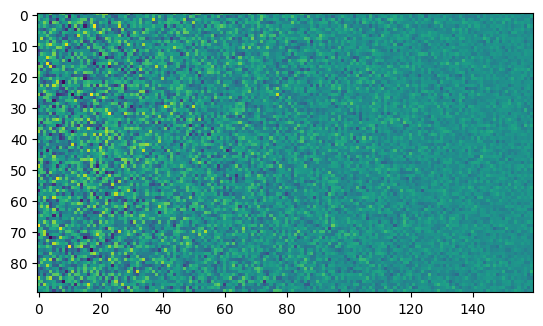

In [7]:
X3_Ls = np.linalg.inv(A3.T @ A3) @ A3.T @ Y3
plt.imshow(X3_Ls.reshape(160, 90).T)